In [55]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.optimizers import Adam

/kaggle/input/facial-keypoints-detection/training.zip
/kaggle/input/facial-keypoints-detection/SampleSubmission.csv
/kaggle/input/facial-keypoints-detection/IdLookupTable.csv
/kaggle/input/facial-keypoints-detection/test.zip


# 1. Import the data

In [90]:
train = pd.read_csv("/kaggle/input/facial-keypoints-detection/training.zip")

# 2. Preprocessing the data

As we see here we have null values in most of our columns so we need to preprocess that somehow

In [91]:
print(train.isnull().sum())

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

We tried imputation last time, but it wouldn't be a good approach since the mean values can be far from the actuall image positions they should be at which would give us bad results.<br>
Maybe it's best we drop the rows with null values which will give us less data but will probably improve our precision.

In [92]:
train = train.dropna()

We will separate the features from the labels first.

In [93]:
x = train['Image']
Y = train.drop(['Image'], axis=1)

Then we need to split the train data from the validation data so we don't have data leakage.

In [94]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_Y, val_Y = train_test_split(x, Y, test_size=0.2)

We're gonna pack our pictures into an array of arrays which are all size 96x96, because the pictures are of that resolution.

In [105]:
reshaped_train_x = []
reshaped_val_x = []

for entry in train_x:
    reshaped_entry = list(map(int, entry.split()))
    reshaped_entry = np.array(reshaped_entry).reshape(96, 96, 1)
    reshaped_train_x.append(reshaped_entry)
    
for entry in val_x:
    reshaped_entry = list(map(int, entry.split()))
    reshaped_entry = np.array(reshaped_entry).reshape(96, 96, 1)
    reshaped_val_x.append(reshaped_entry)

In [108]:
reshaped_train_x = tf.convert_to_tensor(reshaped_train_x, np.float32)
reshaped_val_x = tf.convert_to_tensor(reshaped_val_x, np.float32)

# 3. Defining the model

In [135]:
model = Sequential()

model.add(Lambda(lambda x: x/255.0, input_shape=(96, 96, 1)))
model.add(Conv2D(64, 7, activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(32, 5, activation='relu'))
model.add(MaxPooling2D(2))
model.add(Dropout(0.5))
model.add(Conv2D(16, 3, activation='relu'))
model.add(MaxPooling2D(2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(96, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(30, activation='relu'))

optimizer = keras.optimizers.Adam(lr=0.05)

model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

In [136]:
history = model.fit(
    x=reshaped_train_x,
    y=train_Y,
    batch_size=128,
    epochs=200,
    validation_data=(reshaped_val_x, val_Y)
)

Epoch 1/200
14/14 [==============================] - 36s 2s/step - loss: 1719.1050 - accuracy: 0.0239 - val_loss: 1210.1676 - val_accuracy: 0.0000e+00
Epoch 2/200
14/14 [==============================] - 34s 2s/step - loss: 949.4260 - accuracy: 0.0713 - val_loss: 931.4290 - val_accuracy: 0.0280
Epoch 3/200
14/14 [==============================] - 35s 2s/step - loss: 681.3622 - accuracy: 0.1326 - val_loss: 781.5225 - val_accuracy: 0.2593
Epoch 4/200
14/14 [==============================] - 35s 2s/step - loss: 460.9580 - accuracy: 0.1805 - val_loss: 626.8618 - val_accuracy: 0.7033
Epoch 5/200
14/14 [==============================] - 34s 2s/step - loss: 340.1070 - accuracy: 0.1922 - val_loss: 597.3166 - val_accuracy: 0.7033
Epoch 6/200
14/14 [==============================] - 34s 2s/step - loss: 288.0546 - accuracy: 0.2243 - val_loss: 735.6998 - val_accuracy: 0.7033
Epoch 7/200
14/14 [==============================] - 35s 2s/step - loss: 259.5362 - accuracy: 0.2360 - val_loss: 670.1386 - 

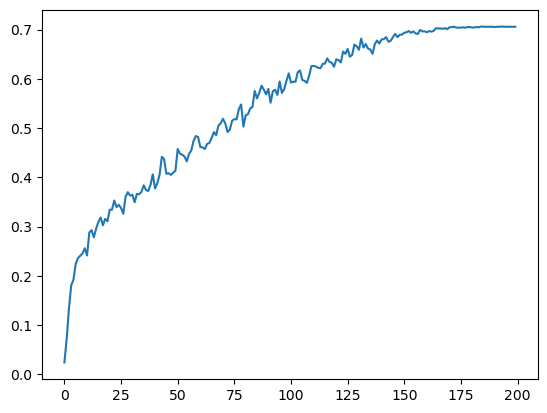

In [137]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])